##Importing Data

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import csv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

In [ ]:
!unzip -q images_2_rs.zip


replace images_2_rs/img_0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
os.rename('images_2_rs', 'images')

In [ ]:
df = pd.read_csv('image_coordinates_180.csv')
# df = df.drop(['Unnamed: 0'],axis=1)
cols = df.columns[:40]
cols = cols.tolist()

df = df[cols]


outer_coords = []
for i in range(1,6):
  outer_coords.append('x2_'+str(i))
  outer_coords.append('y2_'+str(i))
outer_coords.append('img_paths')
df = df[outer_coords]
df = df.iloc[:10000]
train_val_data, test_data = train_test_split(df, test_size=0.15, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.15, random_state=42)
train_data
val_data
test_data = test_data.iloc[28:]
test_data

,x2_1,y2_1,x2_2,y2_2,x2_3,y2_3,x2_4,y2_4,x2_5,y2_5,img_paths
6590,90,167,160,112,143,16,60,48,18,113,images/img_6590.png
8847,90,141,151,110,110,61,42,25,47,103,images/img_8847.png
321,90,131,137,105,119,49,68,60,25,111,images/img_321.png
2678,90,138,146,108,114,56,46,30,50,102,images/img_2678.png
4625,90,149,143,107,132,30,50,35,23,111,images/img_4625.png
...,...,...,...,...,...,...,...,...,...,...,...
967,90,145,128,102,118,50,61,51,47,103,images/img_967.png
6043,90,139,152,110,112,58,42,25,47,103,images/img_6043.png
6879,90,138,154,111,125,41,52,38,42,105,images/img_6879.png
6775,90,134,129,102,133,30,72,65,35,107,images/img_6775.png


In [ ]:
test_df = test_data
img_df = pd.DataFrame(test_df['img_paths'].to_numpy(),columns=['path'])


### Visualizing Actual Data

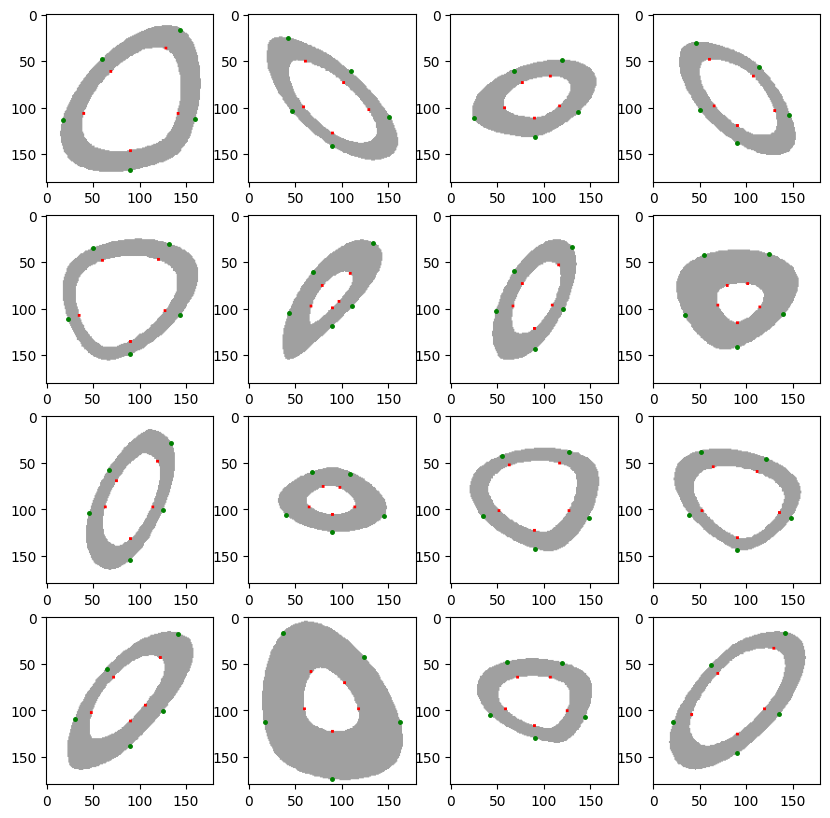

In [ ]:
row = 0 #row less than 1559
plt.figure(figsize=(10, 10))
outer_color = 'green'

for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    img_path = img_df.iloc[row+i,:][0]
    image = cv2.imread(img_path)

    #pt 1
    plt.plot(test_df.iloc[row+i][0],test_df.iloc[row+i][1],marker='.',markersize=5,color=outer_color)


    #pt 2
    plt.plot(test_df.iloc[row+i][2],test_df.iloc[row+i][3],marker='.',markersize=5,color=outer_color)

    #pt 3
    plt.plot(test_df.iloc[row+i][4],test_df.iloc[row+i][5],marker='.',markersize=5,color=outer_color)

    plt.plot(test_df.iloc[row+i][6],test_df.iloc[row+i][7],marker='.',markersize=5,color=outer_color)

    plt.plot(test_df.iloc[row+i][8],test_df.iloc[row+i][9],marker='.',markersize=5,color=outer_color)


    plt.imshow(image)


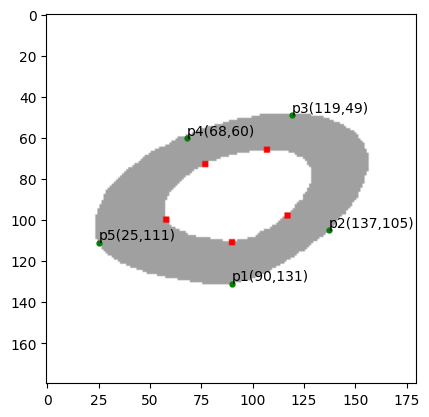

In [ ]:
row=0
i=2
img_path = img_df.iloc[row+i][0]
image = cv2.imread(img_path)
test_df = test_data
outer_color = 'green'
count =0
for x in range(0,10,2):
  y=x+1
  count = count + 1
  plt.plot(test_df.iloc[row+i][x],test_df.iloc[row+i][y],marker='.',markersize=7,color=outer_color)
  plt.text(test_df.iloc[row+i][x], test_df.iloc[row+i][y],'p'+str(count)+'('+str(test_df.iloc[row+i][x])+','+str(test_df.iloc[row+i][y])+')', ha='left', va='bottom')


plt.savefig('exp2_1.png')
plt.imshow(image)


In [ ]:
test_df.iloc[2:]

,x2_1,y2_1,x2_2,y2_2,x2_3,y2_3,x2_4,y2_4,x2_5,y2_5,img_paths
321,90,131,137,105,119,49,68,60,25,111,images/img_321.png
2678,90,138,146,108,114,56,46,30,50,102,images/img_2678.png
4625,90,149,143,107,132,30,50,35,23,111,images/img_4625.png
4949,90,119,111,97,134,29,69,61,43,105,images/img_4949.png
8328,90,143,121,100,130,34,68,60,49,103,images/img_8328.png
...,...,...,...,...,...,...,...,...,...,...,...
967,90,145,128,102,118,50,61,51,47,103,images/img_967.png
6043,90,139,152,110,112,58,42,25,47,103,images/img_6043.png
6879,90,138,154,111,125,41,52,38,42,105,images/img_6879.png
6775,90,134,129,102,133,30,72,65,35,107,images/img_6775.png


##Load the Images into a generator


In [22]:
class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df, X_col, y_col,
                 batch_size,
                 input_size=(180, 180, 3),
                 shuffle=True):
        
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        
        self.n = len(self.df)
        self.n_x1c = df[y_col['x1c']].nunique()
        self.n_y1c = df[y_col['y1c']].nunique()

        self.n_x2c = df[y_col['x2c']].nunique()
        self.n_y2c = df[y_col['y2c']].nunique()
        
        self.n_x3c = df[y_col['x3c']].nunique()
        self.n_y3c = df[y_col['y3c']].nunique()

        self.n_x4c = df[y_col['x4c']].nunique()
        self.n_y4c = df[y_col['y4c']].nunique()
        
        self.n_x5c = df[y_col['x5c']].nunique()
        self.n_y5c = df[y_col['y5c']].nunique()
      
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, path, target_size):
    
      
        image = tf.keras.preprocessing.image.load_img(path)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)

        return image_arr/255
    
    
    def __get_data(self, batches):
            # Generates data containing batch_size samples

            path_batch = batches[self.X_col['path']]
            
            #pt1
            x1c = batches[self.y_col['x1c']]
            y1c= batches[self.y_col['y1c']]
            x2c = batches[self.y_col['x2c']]
            y2c= batches[self.y_col['y2c']]
            x3c = batches[self.y_col['x3c']]
            y3c= batches[self.y_col['y3c']]
            x4c = batches[self.y_col['x4c']]
            y4c= batches[self.y_col['y4c']]
            x5c = batches[self.y_col['x5c']]
            y5c= batches[self.y_col['y5c']]

            
         
            X_batch = np.asarray([self.__get_input(x, self.input_size) for x in path_batch],dtype=np.float32)
            y_batch = np.asarray([(x, y,z,w,a,b,c,d,e,f) for x, y,z,w,a,b,c,d,e,f in zip(y1c, x1c,y2c,x2c,y3c,x3c,y4c,x4c,y5c,x5c)],dtype=np.float32)
            y_batch = y_batch/180


            return X_batch, y_batch
 

        
    def __getitem__(self, index):
            
            batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
            X, y = self.__get_data(batches)        
            return X, y
        
    def __len__(self):
            return self.n // self.batch_size

In [23]:
input_shape = (180,180,3)

traingen = CustomDataGen(train_data,
                         X_col={'path':'img_paths'},
                         y_col={'x1c': 'x2_1', 
                                'y1c': 'y2_1',
                                'x2c': 'x2_2',
                                'y2c': 'y2_2',
                                'x3c': 'x2_3',
                                'y3c': 'y2_3',
                                'x4c': 'x2_4',
                                'y4c': 'y2_4',
                                'x5c': 'x2_5',
                                'y5c': 'y2_5'
                                },
                         batch_size=32, input_size=input_shape)
X, y= traingen[0]


In [24]:
testgen = CustomDataGen(test_data,
                         X_col={'path':'img_paths'},
                         y_col={'x1c': 'x2_1', 
                                'y1c': 'y2_1',
                                'x2c': 'x2_2',
                                'y2c': 'y2_2',
                                'x3c': 'x2_3',
                                'y3c': 'y2_3',
                                'x4c': 'x2_4',
                                'y4c': 'y2_4',
                                'x5c': 'x2_5',
                                'y5c': 'y2_5'
                                },
                         batch_size=32, input_size=input_shape)



In [25]:
valgen = CustomDataGen(val_data,
                         X_col={'path':'img_paths'},
                         y_col={'x1c': 'x2_1', 
                                'y1c': 'y2_1',
                                'x2c': 'x2_2',
                                'y2c': 'y2_2',
                                'x3c': 'x2_3',
                                'y3c': 'y2_3',
                                'x4c': 'x2_4',
                                'y4c': 'y2_4',
                                'x5c': 'x2_5',
                                'y5c': 'y2_5'
                                },
                         batch_size=32, input_size=input_shape)


##Loss Function

In [26]:
def euclid_loss(y_true, y_pred):
  loss =  tf.math.reduce_sum(tf.math.squared_difference(y_pred, y_true),axis=1)
  return tf.math.reduce_mean(loss)*10000

## Model Architecture

In [27]:
channel_size = 128
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(channel_size, kernel_size=(3, 3), strides=(2,2), padding="same", activation="relu"),
        layers.Conv2D(channel_size, kernel_size=(3, 3), strides=(2,2), padding="same", activation="relu"),
        layers.Conv2D(channel_size, kernel_size=(3, 3), strides=(2,2), padding="same", activation="relu"),
        layers.Conv2D(channel_size, kernel_size=(3, 3), strides=(2,2), padding="same", activation="relu"),
        layers.Conv2D(channel_size, kernel_size=(3, 3), strides=(2,2), padding="same", activation="relu"),
        layers.Conv2D(channel_size, kernel_size=(3, 3), strides=(2,2), padding="same", activation="relu"),
        layers.Conv2D(channel_size, kernel_size=(3, 3), strides=(2,2), padding="same", activation="relu"),
        layers.Conv2D(channel_size, kernel_size=(3, 3), strides=(2,2), padding="same", activation="relu"),
       
        layers.Flatten(),
        layers.Dense(channel_size, activation="relu"),
        layers.Dense(channel_size, activation="relu"),
        layers.Dense(channel_size, activation="relu"),
        layers.Dense(channel_size, activation="relu"),
        layers.Dense(channel_size, activation="relu"),
        layers.Dense(channel_size, activation="relu"),
        layers.Dense(channel_size, activation="relu"),
        layers.Dense(channel_size, activation="relu"),

        layers.Dense(10),
    ]
)

opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss=euclid_loss, optimizer=opt)

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 90, 90, 128)       3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 128)       147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 128)         147584    
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 128)         147584    
                                                                 
 conv2d_6 (Conv2D)           (None, 2, 2, 128)         1

In [28]:
history = model.fit(traingen,validation_data=valgen,
          epochs=100
          )


Epoch 1/100
225/225 [==============================] - 24s 39ms/step - loss: 14543.9287 - val_loss: 417.0612
Epoch 2/100
225/225 [==============================] - 9s 39ms/step - loss: 395.7515 - val_loss: 378.7611
Epoch 3/100
225/225 [==============================] - 9s 38ms/step - loss: 353.7160 - val_loss: 327.4334
Epoch 4/100
225/225 [==============================] - 9s 38ms/step - loss: 285.1342 - val_loss: 249.0010
Epoch 5/100
225/225 [==============================] - 9s 38ms/step - loss: 215.4433 - val_loss: 183.8027
Epoch 6/100
225/225 [==============================] - 9s 38ms/step - loss: 165.5820 - val_loss: 151.8859
Epoch 7/100
225/225 [==============================] - 9s 38ms/step - loss: 133.8095 - val_loss: 120.1495
Epoch 8/100
225/225 [==============================] - 9s 38ms/step - loss: 109.8691 - val_loss: 96.0048
Epoch 9/100
225/225 [==============================] - 9s 38ms/step - loss: 90.0497 - val_loss: 79.5480
Epoch 10/100
225/225 [========================

In [29]:
predicted = model.predict(testgen)


46/46 [==============================] - 2s 32ms/step


###Visualization of the predicted data

In [30]:
pred_cols = []
for i in range(1,6):
  pred_cols.append('y2_'+str(i))
  pred_cols.append('x2_'+str(i))
pred_cols

['y2_1',
 'x2_1',
 'y2_2',
 'x2_2',
 'y2_3',
 'x2_3',
 'y2_4',
 'x2_4',
 'y2_5',
 'x2_5']

In [31]:
pred_df = pd.DataFrame(predicted,columns=pred_cols)
pred_df = (pred_df.iloc[:,:]*180).astype('int')

outer_coords = []
for i in range(1,6):
  outer_coords.append('x2_'+str(i))
  outer_coords.append('y2_'+str(i))
outer_coords.append('img_paths')
df = df[outer_coords]
pred_df = pd.DataFrame(pred_df[outer_coords[:10]].to_numpy(),columns=outer_coords[:10])
pred_df
len(predicted)

1472

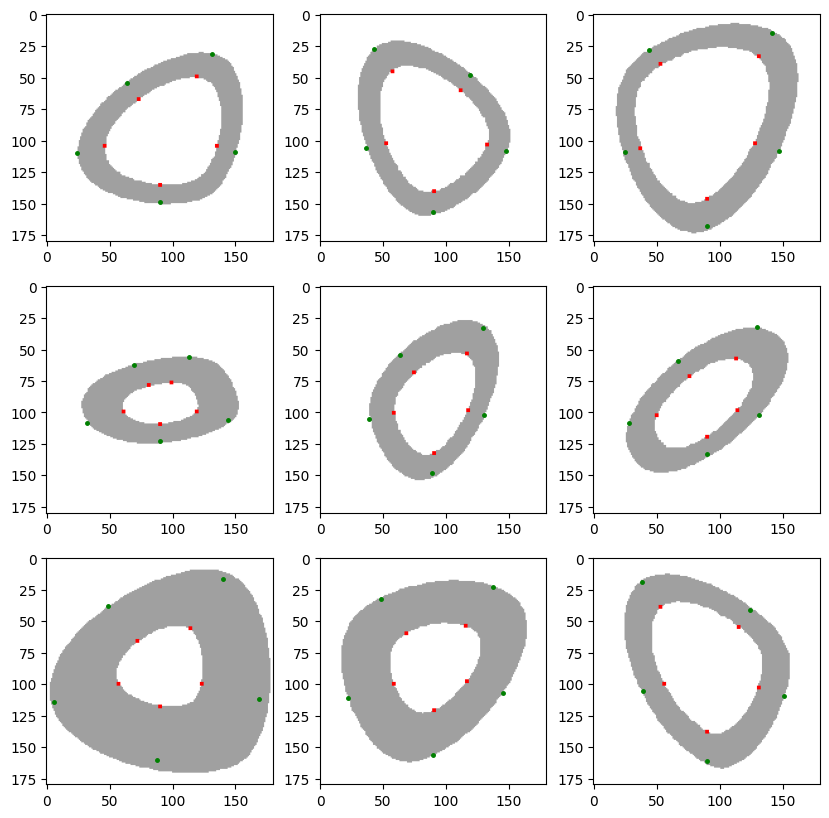

In [32]:
row = 16 #row less than 1559
plt.figure(figsize=(10, 10))
# inner_color= 'purple'
outer_color = 'green'

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img_path = img_df.iloc[row+i,:][0]
    image = cv2.imread(img_path)

    #pt 1
    plt.plot(pred_df['x2_1'][row+i],pred_df['y2_1'][row+i],marker='.',markersize=5,color=outer_color)


    #pt 2
    plt.plot(pred_df['x2_2'][row+i],pred_df['y2_2'][row+i],marker='.',markersize=5,color=outer_color)

    #pt3
    plt.plot(pred_df['x2_3'][row+i],pred_df['y2_3'][row+i],marker='.',markersize=5,color=outer_color)

    plt.plot(pred_df['x2_4'][row+i],pred_df['y2_4'][row+i],marker='.',markersize=5,color=outer_color)
    plt.plot(pred_df['x2_5'][row+i],pred_df['y2_5'][row+i],marker='.',markersize=5,color=outer_color)

    plt.imshow(image)


In [33]:
test_df

,x2_1,y2_1,x2_2,y2_2,x2_3,y2_3,x2_4,y2_4,x2_5,y2_5,img_paths
6590,90,167,160,112,143,16,60,48,18,113,images/img_6590.png
8847,90,141,151,110,110,61,42,25,47,103,images/img_8847.png
321,90,131,137,105,119,49,68,60,25,111,images/img_321.png
2678,90,138,146,108,114,56,46,30,50,102,images/img_2678.png
4625,90,149,143,107,132,30,50,35,23,111,images/img_4625.png
...,...,...,...,...,...,...,...,...,...,...,...
967,90,145,128,102,118,50,61,51,47,103,images/img_967.png
6043,90,139,152,110,112,58,42,25,47,103,images/img_6043.png
6879,90,138,154,111,125,41,52,38,42,105,images/img_6879.png
6775,90,134,129,102,133,30,72,65,35,107,images/img_6775.png


In [34]:
pred_df

,x2_1,y2_1,x2_2,y2_2,x2_3,y2_3,x2_4,y2_4,x2_5,y2_5
0,90,164,160,112,142,17,59,47,17,112
1,89,140,151,109,109,62,41,24,45,103
2,89,127,137,105,118,49,68,60,25,110
3,89,137,146,108,112,56,46,30,49,102
4,90,148,144,106,132,31,48,34,25,110
...,...,...,...,...,...,...,...,...,...,...
1467,89,143,128,102,118,50,60,50,47,102
1468,89,139,153,110,111,58,43,26,47,102
1469,89,137,155,110,124,41,53,39,42,104
1470,89,133,128,101,131,30,72,65,35,106


###Evaluation of Data

In [35]:
df_true = test_data.iloc[:,:10]
df_pred = pred_df.iloc[:,:10]
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate the mean squared error (MSE) for all 10 predicted points
mse = mean_squared_error(df_true, df_pred)
print("MSE: ", mse)

# Calculate the root mean squared error (RMSE) for all 10 predicted points
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

# Calculate the mean absolute error (MAE) for all 10 predicted points
mae = mean_absolute_error(df_true, df_pred)
print("MAE: ", mae)

# Calculate the coefficient of determination (R^2) for all 10 predicted points
r2 = r2_score(df_true, df_pred)
print("R^2: ", r2)



MSE:  1.3241847826086957
RMSE:  1.1507322810318201
MAE:  0.7907608695652175
R^2:  0.8850597391691671


In [36]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate the mean squared error (MSE) for all 10 predicted points
mse = mean_squared_error(df_true, df_pred)
print("MSE: ", mse)

# Calculate the root mean squared error (RMSE) for all 10 predicted points
rmse = np.sqrt(mse)
print("RMSE: ", rmse)

# Calculate the mean absolute error (MAE) for all 10 predicted points
mae = mean_absolute_error(df_true, df_pred)
print("MAE: ", mae)

# Calculate the coefficient of determination (R^2) for all 10 predicted points
r2 = r2_score(df_true, df_pred)
print("R^2: ", r2)


MSE:  1.3241847826086957
RMSE:  1.1507322810318201
MAE:  0.7907608695652175
R^2:  0.8850597391691671


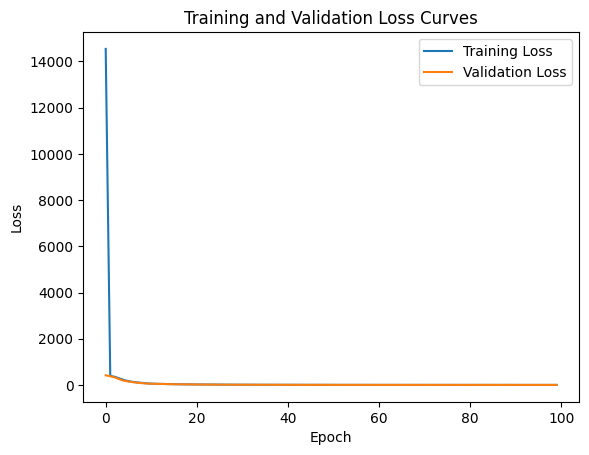

In [37]:

# train the model and get the training history

# plot the training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()